https://www.kaggle.com/code/greatcodes/pytorch-cnn-resnet18-cifar10/notebook

https://pytorch-tutorial.readthedocs.io/en/latest/tutorial/chapter03_intermediate/3_2_2_cnn_resnet_cifar10/

In [ ]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importing Libraries
import os
import copy
import random
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

import matplotlib.pyplot as plt
%matplotlib inline

SEED = 1234

device = "cuda" if torch.cuda.is_available else "cpu"
print(device)

cuda


In [ ]:
from torchvision import transforms
import numpy as np
import torch

# Returns a list of transformations when called

class GetTransforms():
    '''Returns a list of transformations when type as requested amongst train/test
       Transforms('train') = list of transforms to apply on training data
       Transforms('test') = list of transforms to apply on testing data'''

    def __init__(self):
        pass

    def trainparams(self):
        train_transformations = [ #resises the image so it can be perfect for our model.
            transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
            transforms.RandomRotation((-7,7)),     #Rotates the image to a specified angel
            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
            transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
            transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)) #Normalize all the images
            ]

        return train_transformations

    def testparams(self):
        test_transforms = [
            transforms.ToTensor(),
            transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261))
        ]
        return test_transforms

In [ ]:
from torchvision import datasets
from torchvision import transforms


transformations = GetTransforms()
train_transforms = transforms.Compose(transformations.trainparams())
test_transforms = transforms.Compose(transformations.testparams())


class GetCIFAR10_TrainData():
    def __init__(self, dir_name:str):
        self.dirname = dir_name

    def download_train_data(self):
        return datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)

    def download_test_data(self):
        return datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)


In [ ]:
cdata = GetCIFAR10_TrainData(os.chdir(".."))
trainset = cdata.download_train_data()
testset = cdata.download_test_data()

VALID_RATIO = 0.9
n_train_examples = int(len(trainset) * VALID_RATIO)
n_valid_examples = len(trainset) - n_train_examples

trainset, validset = data.random_split(trainset, 
                                           [n_train_examples, n_valid_examples])

validset = copy.deepcopy(validset)
validset.dataset.transform = test_transforms

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
len(trainset), len(validset), len(testset)

(45000, 5000, 10000)

In [ ]:
BATCH_SIZE = 512

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

# The Model - RESNET18


In [ ]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

In [ ]:
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.dropout1 = nn.Dropout(0.1)
        
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout2 = nn.Dropout(0.1)
        
        self.downsample = downsample

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        # out = self.dropout1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        # out = self.dropout2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        
        self.in_channels = 16
        
        self.conv = conv3x3(in_channels=3, out_channels=16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self.make_layer(block=block, out_channels=16, blocks=layers[0], stride=1)
        self.layer2 = self.make_layer(block=block, out_channels=32, blocks=layers[1], stride=2)
        self.layer3 = self.make_layer(block=block, out_channels=64, blocks=layers[2], stride=2)
        self.layer4 = self.make_layer(block=block, out_channels=128, blocks=layers[3], stride=2)
        self.layer5 = self.make_layer(block=block, out_channels=256, blocks=layers[4], stride=2)

        # self.avg_pool = nn.AvgPool2d(1)
        self.fc = nn.Linear(1024, num_classes)
        # self.fc = nn.Linear(128, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        # out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return F.log_softmax(out, dim=-1)

def ResNet18():
    return ResNet(ResidualBlock, [2, 2, 2, 2, 2])
    # return ResNet(ResidualBlock, [2, 2, 2])

In [ ]:
# Importing Model and printing Summary
model = ResNet18().to(device)
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]           2,304
       BatchNorm2d-8           [-1, 16, 32, 32]              32
              ReLU-9           [-1, 16, 32, 32]               0
    ResidualBlock-10           [-1, 16, 32, 32]               0
           Conv2d-11           [-1, 16, 32, 32]           2,304
      BatchNorm2d-12           [-1, 16, 32, 32]              32
             ReLU-13           [-1, 16, 32, 32]               0
           Conv2d-14           [-1, 16,

In [ ]:
from tqdm import tqdm
from torch import nn
import torch.nn
from torch.functional import F
import os


def model_training(model, device, train_dataloader, optimizer, train_acc, train_losses):
            
    model.train()
    pbar = tqdm(train_dataloader)
    correct = 0
    processed = 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.nll_loss(y_pred, target)
        

        # train_losses.append(loss.item())
        loss.backward()
        optimizer.step()

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        
        # print statistics
        
        running_loss += loss.item()
        pbar.set_description(desc=f'Batch_id={batch_idx} Batch Loss={loss.item()} Running Loss={running_loss} Running Accuracy={100*correct/processed:0.2f}')
        # train_acc.append(100*correct/processed)
    
    train_losses.append(running_loss)
    train_acc.append(100*correct/processed)

In [ ]:
import torch
import os
from torch.functional import F

cwd = os.getcwd()

def model_testing(model, device, test_dataloader, test_acc, test_losses, misclassified = []):
    
    model.eval()
    test_loss = 0
    correct = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    # label = 0
    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    with torch.no_grad():

        for index, (data, target) in enumerate(test_dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            
            for d,i,j in zip(data, pred, target):
                if i != j:
                    misclassified.append([d.cpu(),i[0].cpu(),j.cpu()])

            test_loss += F.nll_loss(output, target, reduction='sum').item()
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))
    
    test_acc.append(100. * correct / len(test_dataloader.dataset))
    return misclassified, correct / len(test_dataloader.dataset)

In [ ]:
def model_evaluation(model, device, loader):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in loader:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = F.nll_loss(y_pred, y)
        
            pred = y_pred.argmax(dim=1, keepdim=True)
            acc = pred.eq(y.view_as(pred)).sum()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    epoch_loss / len(loader.dataset), epoch_acc, len(loader.dataset),
    100. * epoch_acc / len(loader.dataset)))

    return epoch_loss, epoch_acc / len(loader.dataset)

In [ ]:
# Defining parameters

criterion = nn.CrossEntropyLoss()

# optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
# scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

In [ ]:
import pandas

def save_to_csv(csvname, train_losses, train_accs, test_losses, test_accs):
  df = pandas.DataFrame()
  df["epoch"] = [i+1 for i in range(len(train_losses))]
  df["train_loss"] = train_losses
  df["test_loss"] = test_losses
  df["train_acc"] = train_accs
  df["test_acc"] = test_accs
  df.to_csv(csvname)

In [ ]:
# Training the model

train_acc = []
train_losses = []
valid_accs = []
valid_losses = []
test_acc = []
test_losses = []
min_valid_loss = None
max_acc = None

EPOCHS = 80

for i in range(EPOCHS):
    print(f'EPOCHS : {i}')
    model_training(model, device, trainloader, optimizer, train_acc, train_losses)

    # Validating the model for the current epoch
    valid_loss, valid_acc = model_evaluation(model, device, validloader)  

    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    if not min_valid_loss:
      min_valid_loss = valid_loss
    else:
      if valid_loss < min_valid_loss:
        min_valid_loss = valid_loss
        torch.save(model, "best_model.pickle")

    scheduler.step(train_losses[-1])
    # scheduler.step(valid_loss)

    misclassified, test_acc2 = model_testing(model, device, testloader, test_acc, test_losses)

    if not max_acc:
      max_acc = test_acc2
    else:
      if test_acc2 > max_acc:
        max_acc = test_acc2
        torch.save(model, "best_test_acc_model.pickle")

    save_to_csv("11_resnet_2_2_2_2_2_inchannels_16.csv", train_losses, train_acc, test_losses, test_acc)
  

EPOCHS : 0


Batch_id=87 Batch Loss=1.533178687095642 Running Loss=160.82053685188293 Running Accuracy=33.47: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]



Validation set: Average loss: 0.0031, Accuracy: 2237/5000 (44.74%)


Test set: Average loss: 1.5387, Accuracy: 4392/10000 (43.92%)

EPOCHS : 1


Batch_id=87 Batch Loss=1.3206218481063843 Running Loss=127.25424754619598 Running Accuracy=47.39: 100%|██████████| 88/88 [00:32<00:00,  2.74it/s]



Validation set: Average loss: 0.0026, Accuracy: 2644/5000 (52.88%)


Test set: Average loss: 1.3077, Accuracy: 5281/10000 (52.81%)

EPOCHS : 2


Batch_id=87 Batch Loss=1.1718289852142334 Running Loss=110.34428369998932 Running Accuracy=54.73: 100%|██████████| 88/88 [00:31<00:00,  2.81it/s]



Validation set: Average loss: 0.0023, Accuracy: 2970/5000 (59.40%)


Test set: Average loss: 1.1445, Accuracy: 5856/10000 (58.56%)

EPOCHS : 3


Batch_id=87 Batch Loss=0.9845192432403564 Running Loss=97.32170605659485 Running Accuracy=60.29: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]



Validation set: Average loss: 0.0022, Accuracy: 3107/5000 (62.14%)


Test set: Average loss: 1.0886, Accuracy: 6229/10000 (62.29%)

EPOCHS : 4


Batch_id=87 Batch Loss=1.0126570463180542 Running Loss=87.80799752473831 Running Accuracy=64.53: 100%|██████████| 88/88 [00:30<00:00,  2.86it/s]



Validation set: Average loss: 0.0019, Accuracy: 3307/5000 (66.14%)


Test set: Average loss: 0.9433, Accuracy: 6646/10000 (66.46%)

EPOCHS : 5


Batch_id=87 Batch Loss=0.8545123338699341 Running Loss=79.60515213012695 Running Accuracy=68.11: 100%|██████████| 88/88 [00:31<00:00,  2.77it/s]



Validation set: Average loss: 0.0017, Accuracy: 3444/5000 (68.88%)


Test set: Average loss: 0.8871, Accuracy: 6890/10000 (68.90%)

EPOCHS : 6


Batch_id=87 Batch Loss=0.7885748744010925 Running Loss=73.97141057252884 Running Accuracy=70.31: 100%|██████████| 88/88 [00:29<00:00,  2.95it/s]



Validation set: Average loss: 0.0018, Accuracy: 3381/5000 (67.62%)


Test set: Average loss: 0.9499, Accuracy: 6718/10000 (67.18%)

EPOCHS : 7


Batch_id=87 Batch Loss=0.7396567463874817 Running Loss=69.27017080783844 Running Accuracy=72.11: 100%|██████████| 88/88 [00:31<00:00,  2.80it/s]



Validation set: Average loss: 0.0015, Accuracy: 3651/5000 (73.02%)


Test set: Average loss: 0.7830, Accuracy: 7258/10000 (72.58%)

EPOCHS : 8


Batch_id=87 Batch Loss=0.7254542112350464 Running Loss=64.09673744440079 Running Accuracy=74.34: 100%|██████████| 88/88 [00:31<00:00,  2.79it/s]



Validation set: Average loss: 0.0015, Accuracy: 3727/5000 (74.54%)


Test set: Average loss: 0.7541, Accuracy: 7413/10000 (74.13%)

EPOCHS : 9


Batch_id=87 Batch Loss=0.6977573037147522 Running Loss=60.77505028247833 Running Accuracy=75.78: 100%|██████████| 88/88 [00:30<00:00,  2.89it/s]



Validation set: Average loss: 0.0014, Accuracy: 3791/5000 (75.82%)


Test set: Average loss: 0.7165, Accuracy: 7549/10000 (75.49%)

EPOCHS : 10


Batch_id=87 Batch Loss=0.6153760552406311 Running Loss=57.030347406864166 Running Accuracy=77.20: 100%|██████████| 88/88 [00:31<00:00,  2.77it/s]



Validation set: Average loss: 0.0013, Accuracy: 3872/5000 (77.44%)


Test set: Average loss: 0.6837, Accuracy: 7634/10000 (76.34%)

EPOCHS : 11


Batch_id=87 Batch Loss=0.5943223237991333 Running Loss=54.74453654885292 Running Accuracy=77.96: 100%|██████████| 88/88 [00:31<00:00,  2.79it/s]



Validation set: Average loss: 0.0013, Accuracy: 3896/5000 (77.92%)


Test set: Average loss: 0.6944, Accuracy: 7679/10000 (76.79%)

EPOCHS : 12


Batch_id=87 Batch Loss=0.6166963577270508 Running Loss=51.68217560648918 Running Accuracy=79.25: 100%|██████████| 88/88 [00:30<00:00,  2.87it/s]



Validation set: Average loss: 0.0013, Accuracy: 3877/5000 (77.54%)


Test set: Average loss: 0.6956, Accuracy: 7667/10000 (76.67%)

EPOCHS : 13


Batch_id=87 Batch Loss=0.5774807929992676 Running Loss=49.22520875930786 Running Accuracy=80.32: 100%|██████████| 88/88 [00:31<00:00,  2.77it/s]



Validation set: Average loss: 0.0013, Accuracy: 3894/5000 (77.88%)


Test set: Average loss: 0.6707, Accuracy: 7772/10000 (77.72%)

EPOCHS : 14


Batch_id=87 Batch Loss=0.6065275073051453 Running Loss=46.81779929995537 Running Accuracy=81.38: 100%|██████████| 88/88 [00:31<00:00,  2.77it/s]



Validation set: Average loss: 0.0013, Accuracy: 3924/5000 (78.48%)


Test set: Average loss: 0.6845, Accuracy: 7704/10000 (77.04%)

EPOCHS : 15


Batch_id=87 Batch Loss=0.4993970990180969 Running Loss=44.53881257772446 Running Accuracy=82.19: 100%|██████████| 88/88 [00:31<00:00,  2.83it/s]



Validation set: Average loss: 0.0013, Accuracy: 3929/5000 (78.58%)


Test set: Average loss: 0.6757, Accuracy: 7770/10000 (77.70%)

EPOCHS : 16


Batch_id=87 Batch Loss=0.5340270400047302 Running Loss=43.286661982536316 Running Accuracy=82.44: 100%|██████████| 88/88 [00:31<00:00,  2.78it/s]



Validation set: Average loss: 0.0012, Accuracy: 3992/5000 (79.84%)


Test set: Average loss: 0.6477, Accuracy: 7874/10000 (78.74%)

EPOCHS : 17


Batch_id=87 Batch Loss=0.49629202485084534 Running Loss=41.05772063136101 Running Accuracy=83.48: 100%|██████████| 88/88 [00:31<00:00,  2.75it/s]



Validation set: Average loss: 0.0012, Accuracy: 3941/5000 (78.82%)


Test set: Average loss: 0.6297, Accuracy: 7932/10000 (79.32%)

EPOCHS : 18


Batch_id=87 Batch Loss=0.44800588488578796 Running Loss=39.482764571905136 Running Accuracy=84.01: 100%|██████████| 88/88 [00:30<00:00,  2.87it/s]



Validation set: Average loss: 0.0012, Accuracy: 4012/5000 (80.24%)


Test set: Average loss: 0.6064, Accuracy: 8001/10000 (80.01%)

EPOCHS : 19


Batch_id=87 Batch Loss=0.4128808081150055 Running Loss=38.02863824367523 Running Accuracy=84.57: 100%|██████████| 88/88 [00:31<00:00,  2.76it/s]



Validation set: Average loss: 0.0013, Accuracy: 3978/5000 (79.56%)


Test set: Average loss: 0.6979, Accuracy: 7798/10000 (77.98%)

EPOCHS : 20


Batch_id=87 Batch Loss=0.36146196722984314 Running Loss=36.36710104346275 Running Accuracy=85.44: 100%|██████████| 88/88 [00:31<00:00,  2.75it/s]



Validation set: Average loss: 0.0012, Accuracy: 4010/5000 (80.20%)


Test set: Average loss: 0.6239, Accuracy: 8015/10000 (80.15%)

EPOCHS : 21


Batch_id=87 Batch Loss=0.39267536997795105 Running Loss=35.65307918190956 Running Accuracy=85.67: 100%|██████████| 88/88 [00:30<00:00,  2.88it/s]



Validation set: Average loss: 0.0013, Accuracy: 4021/5000 (80.42%)


Test set: Average loss: 0.6639, Accuracy: 7917/10000 (79.17%)

EPOCHS : 22


Batch_id=87 Batch Loss=0.35337719321250916 Running Loss=34.17348563671112 Running Accuracy=86.25: 100%|██████████| 88/88 [00:31<00:00,  2.75it/s]



Validation set: Average loss: 0.0013, Accuracy: 3970/5000 (79.40%)


Test set: Average loss: 0.6902, Accuracy: 7844/10000 (78.44%)

EPOCHS : 23


Batch_id=87 Batch Loss=0.4182548522949219 Running Loss=32.77568516135216 Running Accuracy=86.90: 100%|██████████| 88/88 [00:31<00:00,  2.77it/s]



Validation set: Average loss: 0.0012, Accuracy: 4077/5000 (81.54%)


Test set: Average loss: 0.6307, Accuracy: 8042/10000 (80.42%)

EPOCHS : 24


Batch_id=87 Batch Loss=0.41881251335144043 Running Loss=30.932879835367203 Running Accuracy=87.54: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]



Validation set: Average loss: 0.0012, Accuracy: 4064/5000 (81.28%)


Test set: Average loss: 0.6407, Accuracy: 8060/10000 (80.60%)

EPOCHS : 25


Batch_id=87 Batch Loss=0.3825121521949768 Running Loss=30.307512044906616 Running Accuracy=87.76: 100%|██████████| 88/88 [00:31<00:00,  2.78it/s]



Validation set: Average loss: 0.0013, Accuracy: 4005/5000 (80.10%)


Test set: Average loss: 0.6926, Accuracy: 7896/10000 (78.96%)

EPOCHS : 26


Batch_id=87 Batch Loss=0.32460319995880127 Running Loss=29.10948197543621 Running Accuracy=88.28: 100%|██████████| 88/88 [00:31<00:00,  2.78it/s]



Validation set: Average loss: 0.0013, Accuracy: 4040/5000 (80.80%)


Test set: Average loss: 0.6703, Accuracy: 8032/10000 (80.32%)

EPOCHS : 27


Batch_id=87 Batch Loss=0.36590084433555603 Running Loss=28.24385115504265 Running Accuracy=88.61: 100%|██████████| 88/88 [00:30<00:00,  2.90it/s]



Validation set: Average loss: 0.0012, Accuracy: 4124/5000 (82.48%)


Test set: Average loss: 0.6545, Accuracy: 8103/10000 (81.03%)

EPOCHS : 28


Batch_id=87 Batch Loss=0.3609766960144043 Running Loss=26.861616909503937 Running Accuracy=89.14: 100%|██████████| 88/88 [00:31<00:00,  2.83it/s]



Validation set: Average loss: 0.0013, Accuracy: 4063/5000 (81.26%)


Test set: Average loss: 0.7020, Accuracy: 8001/10000 (80.01%)

EPOCHS : 29


Batch_id=87 Batch Loss=0.2853444218635559 Running Loss=26.491952121257782 Running Accuracy=89.38: 100%|██████████| 88/88 [00:31<00:00,  2.81it/s]



Validation set: Average loss: 0.0012, Accuracy: 4088/5000 (81.76%)


Test set: Average loss: 0.6434, Accuracy: 8108/10000 (81.08%)

EPOCHS : 30


Batch_id=87 Batch Loss=0.27582648396492004 Running Loss=24.78780046105385 Running Accuracy=89.98: 100%|██████████| 88/88 [00:30<00:00,  2.90it/s]



Validation set: Average loss: 0.0012, Accuracy: 4097/5000 (81.94%)


Test set: Average loss: 0.6691, Accuracy: 8116/10000 (81.16%)

EPOCHS : 31


Batch_id=87 Batch Loss=0.2831448018550873 Running Loss=24.323325857520103 Running Accuracy=90.25: 100%|██████████| 88/88 [00:31<00:00,  2.80it/s]



Validation set: Average loss: 0.0013, Accuracy: 4052/5000 (81.04%)


Test set: Average loss: 0.6645, Accuracy: 8061/10000 (80.61%)

EPOCHS : 32


Batch_id=87 Batch Loss=0.27606549859046936 Running Loss=23.043053463101387 Running Accuracy=90.52: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]



Validation set: Average loss: 0.0012, Accuracy: 4091/5000 (81.82%)


Test set: Average loss: 0.6638, Accuracy: 8126/10000 (81.26%)

EPOCHS : 33


Batch_id=87 Batch Loss=0.23807640373706818 Running Loss=22.4855527728796 Running Accuracy=90.82: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]



Validation set: Average loss: 0.0012, Accuracy: 4067/5000 (81.34%)


Test set: Average loss: 0.6651, Accuracy: 8121/10000 (81.21%)

EPOCHS : 34


Batch_id=87 Batch Loss=0.23973532021045685 Running Loss=22.38485223054886 Running Accuracy=91.04: 100%|██████████| 88/88 [00:31<00:00,  2.79it/s]



Validation set: Average loss: 0.0012, Accuracy: 4101/5000 (82.02%)


Test set: Average loss: 0.6311, Accuracy: 8185/10000 (81.85%)

EPOCHS : 35


Batch_id=87 Batch Loss=0.29700881242752075 Running Loss=21.278119310736656 Running Accuracy=91.56: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]



Validation set: Average loss: 0.0013, Accuracy: 4094/5000 (81.88%)


Test set: Average loss: 0.6819, Accuracy: 8129/10000 (81.29%)

EPOCHS : 36


Batch_id=87 Batch Loss=0.24956239759922028 Running Loss=20.108641102910042 Running Accuracy=91.89: 100%|██████████| 88/88 [00:31<00:00,  2.81it/s]



Validation set: Average loss: 0.0013, Accuracy: 4065/5000 (81.30%)


Test set: Average loss: 0.7329, Accuracy: 8033/10000 (80.33%)

EPOCHS : 37


Batch_id=87 Batch Loss=0.2583654820919037 Running Loss=19.867294535040855 Running Accuracy=91.74: 100%|██████████| 88/88 [00:31<00:00,  2.79it/s]



Validation set: Average loss: 0.0013, Accuracy: 4095/5000 (81.90%)


Test set: Average loss: 0.7000, Accuracy: 8136/10000 (81.36%)

EPOCHS : 38


Batch_id=87 Batch Loss=0.22634907066822052 Running Loss=19.2696775496006 Running Accuracy=92.27: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]



Validation set: Average loss: 0.0013, Accuracy: 4144/5000 (82.88%)


Test set: Average loss: 0.6832, Accuracy: 8179/10000 (81.79%)

EPOCHS : 39


Batch_id=87 Batch Loss=0.23078851401805878 Running Loss=18.630986973643303 Running Accuracy=92.31: 100%|██████████| 88/88 [00:30<00:00,  2.84it/s]



Validation set: Average loss: 0.0014, Accuracy: 4093/5000 (81.86%)


Test set: Average loss: 0.7537, Accuracy: 8095/10000 (80.95%)

EPOCHS : 40


Batch_id=87 Batch Loss=0.19586136937141418 Running Loss=18.08217054605484 Running Accuracy=92.66: 100%|██████████| 88/88 [00:30<00:00,  2.84it/s]



Validation set: Average loss: 0.0012, Accuracy: 4154/5000 (83.08%)


Test set: Average loss: 0.6618, Accuracy: 8264/10000 (82.64%)

EPOCHS : 41


Batch_id=87 Batch Loss=0.2595674693584442 Running Loss=17.646524220705032 Running Accuracy=92.83: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]



Validation set: Average loss: 0.0012, Accuracy: 4163/5000 (83.26%)


Test set: Average loss: 0.6642, Accuracy: 8211/10000 (82.11%)

EPOCHS : 42


Batch_id=87 Batch Loss=0.19901026785373688 Running Loss=17.123542740941048 Running Accuracy=93.09: 100%|██████████| 88/88 [00:31<00:00,  2.79it/s]



Validation set: Average loss: 0.0013, Accuracy: 4117/5000 (82.34%)


Test set: Average loss: 0.7099, Accuracy: 8141/10000 (81.41%)

EPOCHS : 43


Batch_id=87 Batch Loss=0.1531604528427124 Running Loss=16.603897035121918 Running Accuracy=93.28: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]



Validation set: Average loss: 0.0014, Accuracy: 4072/5000 (81.44%)


Test set: Average loss: 0.7453, Accuracy: 8095/10000 (80.95%)

EPOCHS : 44


Batch_id=87 Batch Loss=0.22233857214450836 Running Loss=15.826426811516285 Running Accuracy=93.60: 100%|██████████| 88/88 [00:29<00:00,  2.96it/s]



Validation set: Average loss: 0.0012, Accuracy: 4159/5000 (83.18%)


Test set: Average loss: 0.6773, Accuracy: 8259/10000 (82.59%)

EPOCHS : 45


Batch_id=87 Batch Loss=0.190532386302948 Running Loss=15.26406355202198 Running Accuracy=93.86: 100%|██████████| 88/88 [00:30<00:00,  2.86it/s]



Validation set: Average loss: 0.0014, Accuracy: 4119/5000 (82.38%)


Test set: Average loss: 0.7517, Accuracy: 8160/10000 (81.60%)

EPOCHS : 46


Batch_id=87 Batch Loss=0.20982985198497772 Running Loss=14.591292813420296 Running Accuracy=93.98: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]



Validation set: Average loss: 0.0013, Accuracy: 4159/5000 (83.18%)


Test set: Average loss: 0.7085, Accuracy: 8184/10000 (81.84%)

EPOCHS : 47


Batch_id=87 Batch Loss=0.1820976883172989 Running Loss=14.385417528450489 Running Accuracy=94.22: 100%|██████████| 88/88 [00:31<00:00,  2.84it/s]



Validation set: Average loss: 0.0014, Accuracy: 4171/5000 (83.42%)


Test set: Average loss: 0.7422, Accuracy: 8211/10000 (82.11%)

EPOCHS : 48


Batch_id=87 Batch Loss=0.20752063393592834 Running Loss=14.19315978884697 Running Accuracy=94.31: 100%|██████████| 88/88 [00:30<00:00,  2.87it/s]



Validation set: Average loss: 0.0014, Accuracy: 4142/5000 (82.84%)


Test set: Average loss: 0.7464, Accuracy: 8175/10000 (81.75%)

EPOCHS : 49


Batch_id=87 Batch Loss=0.1720251441001892 Running Loss=13.964108750224113 Running Accuracy=94.37: 100%|██████████| 88/88 [00:29<00:00,  2.97it/s]



Validation set: Average loss: 0.0013, Accuracy: 4169/5000 (83.38%)


Test set: Average loss: 0.7296, Accuracy: 8231/10000 (82.31%)

EPOCHS : 50


Batch_id=87 Batch Loss=0.15301819145679474 Running Loss=13.769850127398968 Running Accuracy=94.46: 100%|██████████| 88/88 [00:30<00:00,  2.86it/s]



Validation set: Average loss: 0.0013, Accuracy: 4161/5000 (83.22%)


Test set: Average loss: 0.7351, Accuracy: 8253/10000 (82.53%)

EPOCHS : 51


Batch_id=87 Batch Loss=0.14800839126110077 Running Loss=12.568948060274124 Running Accuracy=94.96: 100%|██████████| 88/88 [00:30<00:00,  2.87it/s]



Validation set: Average loss: 0.0015, Accuracy: 4119/5000 (82.38%)


Test set: Average loss: 0.7699, Accuracy: 8166/10000 (81.66%)

EPOCHS : 52


Batch_id=87 Batch Loss=0.1450144350528717 Running Loss=12.23320558667183 Running Accuracy=95.08: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]



Validation set: Average loss: 0.0013, Accuracy: 4178/5000 (83.56%)


Test set: Average loss: 0.7271, Accuracy: 8294/10000 (82.94%)

EPOCHS : 53


Batch_id=87 Batch Loss=0.15777170658111572 Running Loss=11.97196364402771 Running Accuracy=95.24: 100%|██████████| 88/88 [00:31<00:00,  2.82it/s]



Validation set: Average loss: 0.0013, Accuracy: 4193/5000 (83.86%)


Test set: Average loss: 0.7187, Accuracy: 8282/10000 (82.82%)

EPOCHS : 54


Batch_id=87 Batch Loss=0.14578847587108612 Running Loss=12.051414892077446 Running Accuracy=95.10: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]



Validation set: Average loss: 0.0014, Accuracy: 4166/5000 (83.32%)


Test set: Average loss: 0.7640, Accuracy: 8180/10000 (81.80%)

EPOCHS : 55


Batch_id=87 Batch Loss=0.16455835103988647 Running Loss=11.61720584332943 Running Accuracy=95.29: 100%|██████████| 88/88 [00:30<00:00,  2.86it/s]



Validation set: Average loss: 0.0014, Accuracy: 4179/5000 (83.58%)


Test set: Average loss: 0.7402, Accuracy: 8266/10000 (82.66%)

EPOCHS : 56


Batch_id=87 Batch Loss=0.13102662563323975 Running Loss=11.025275856256485 Running Accuracy=95.54: 100%|██████████| 88/88 [00:31<00:00,  2.82it/s]



Validation set: Average loss: 0.0013, Accuracy: 4206/5000 (84.12%)


Test set: Average loss: 0.7067, Accuracy: 8326/10000 (83.26%)

EPOCHS : 57


Batch_id=87 Batch Loss=0.09453301131725311 Running Loss=11.516102276742458 Running Accuracy=95.33: 100%|██████████| 88/88 [00:29<00:00,  2.97it/s]



Validation set: Average loss: 0.0014, Accuracy: 4169/5000 (83.38%)


Test set: Average loss: 0.7919, Accuracy: 8241/10000 (82.41%)

EPOCHS : 58


Batch_id=87 Batch Loss=0.13058806955814362 Running Loss=10.90847610682249 Running Accuracy=95.53: 100%|██████████| 88/88 [00:31<00:00,  2.81it/s]



Validation set: Average loss: 0.0014, Accuracy: 4169/5000 (83.38%)


Test set: Average loss: 0.7505, Accuracy: 8308/10000 (83.08%)

EPOCHS : 59


Batch_id=87 Batch Loss=0.10437758266925812 Running Loss=10.172229520976543 Running Accuracy=95.89: 100%|██████████| 88/88 [00:30<00:00,  2.89it/s]



Validation set: Average loss: 0.0014, Accuracy: 4168/5000 (83.36%)


Test set: Average loss: 0.7606, Accuracy: 8206/10000 (82.06%)

EPOCHS : 60


Batch_id=87 Batch Loss=0.12344255298376083 Running Loss=10.389528825879097 Running Accuracy=95.81: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]



Validation set: Average loss: 0.0013, Accuracy: 4199/5000 (83.98%)


Test set: Average loss: 0.7423, Accuracy: 8274/10000 (82.74%)

EPOCHS : 61


Batch_id=87 Batch Loss=0.11852353066205978 Running Loss=10.034887284040451 Running Accuracy=95.96: 100%|██████████| 88/88 [00:31<00:00,  2.84it/s]



Validation set: Average loss: 0.0013, Accuracy: 4186/5000 (83.72%)


Test set: Average loss: 0.7259, Accuracy: 8275/10000 (82.75%)

EPOCHS : 62


Batch_id=87 Batch Loss=0.11014486849308014 Running Loss=9.729262430220842 Running Accuracy=96.09: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]



Validation set: Average loss: 0.0014, Accuracy: 4191/5000 (83.82%)


Test set: Average loss: 0.7470, Accuracy: 8276/10000 (82.76%)

EPOCHS : 63


Batch_id=87 Batch Loss=0.14805231988430023 Running Loss=9.883279256522655 Running Accuracy=96.02: 100%|██████████| 88/88 [00:31<00:00,  2.81it/s]



Validation set: Average loss: 0.0014, Accuracy: 4213/5000 (84.26%)


Test set: Average loss: 0.7431, Accuracy: 8301/10000 (83.01%)

EPOCHS : 64


Batch_id=87 Batch Loss=0.0864214077591896 Running Loss=9.472432494163513 Running Accuracy=96.25: 100%|██████████| 88/88 [00:31<00:00,  2.78it/s]



Validation set: Average loss: 0.0014, Accuracy: 4202/5000 (84.04%)


Test set: Average loss: 0.7429, Accuracy: 8289/10000 (82.89%)

EPOCHS : 65


Batch_id=87 Batch Loss=0.084958016872406 Running Loss=9.274137899279594 Running Accuracy=96.32: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]



Validation set: Average loss: 0.0014, Accuracy: 4202/5000 (84.04%)


Test set: Average loss: 0.7335, Accuracy: 8332/10000 (83.32%)

EPOCHS : 66


Batch_id=87 Batch Loss=0.04857715219259262 Running Loss=8.66559224948287 Running Accuracy=96.47: 100%|██████████| 88/88 [00:31<00:00,  2.76it/s]



Validation set: Average loss: 0.0014, Accuracy: 4213/5000 (84.26%)


Test set: Average loss: 0.7403, Accuracy: 8356/10000 (83.56%)

EPOCHS : 67


Batch_id=87 Batch Loss=0.06517712026834488 Running Loss=8.70959983766079 Running Accuracy=96.48: 100%|██████████| 88/88 [00:31<00:00,  2.79it/s]



Validation set: Average loss: 0.0015, Accuracy: 4197/5000 (83.94%)


Test set: Average loss: 0.7939, Accuracy: 8245/10000 (82.45%)

EPOCHS : 68


Batch_id=87 Batch Loss=0.10146370530128479 Running Loss=8.262398581951857 Running Accuracy=96.58: 100%|██████████| 88/88 [00:30<00:00,  2.86it/s]



Validation set: Average loss: 0.0014, Accuracy: 4236/5000 (84.72%)


Test set: Average loss: 0.7779, Accuracy: 8289/10000 (82.89%)

EPOCHS : 69


Batch_id=87 Batch Loss=0.09216786175966263 Running Loss=8.407143589109182 Running Accuracy=96.67: 100%|██████████| 88/88 [00:31<00:00,  2.77it/s]



Validation set: Average loss: 0.0014, Accuracy: 4192/5000 (83.84%)


Test set: Average loss: 0.7740, Accuracy: 8290/10000 (82.90%)

EPOCHS : 70


Batch_id=87 Batch Loss=0.08586664497852325 Running Loss=8.009552504867315 Running Accuracy=96.70: 100%|██████████| 88/88 [00:30<00:00,  2.85it/s]



Validation set: Average loss: 0.0015, Accuracy: 4201/5000 (84.02%)


Test set: Average loss: 0.7756, Accuracy: 8317/10000 (83.17%)

EPOCHS : 71


Batch_id=87 Batch Loss=0.11325112730264664 Running Loss=7.844544962048531 Running Accuracy=96.91: 100%|██████████| 88/88 [00:30<00:00,  2.84it/s]



Validation set: Average loss: 0.0014, Accuracy: 4244/5000 (84.88%)


Test set: Average loss: 0.7619, Accuracy: 8343/10000 (83.43%)

EPOCHS : 72


Batch_id=87 Batch Loss=0.04857632890343666 Running Loss=7.803324863314629 Running Accuracy=96.88: 100%|██████████| 88/88 [00:32<00:00,  2.74it/s]



Validation set: Average loss: 0.0015, Accuracy: 4207/5000 (84.14%)


Test set: Average loss: 0.7828, Accuracy: 8300/10000 (83.00%)

EPOCHS : 73


Batch_id=87 Batch Loss=0.06295560300350189 Running Loss=7.67612523958087 Running Accuracy=96.90: 100%|██████████| 88/88 [00:31<00:00,  2.82it/s]



Validation set: Average loss: 0.0015, Accuracy: 4156/5000 (83.12%)


Test set: Average loss: 0.8375, Accuracy: 8262/10000 (82.62%)

EPOCHS : 74


Batch_id=87 Batch Loss=0.07175130397081375 Running Loss=7.870756812393665 Running Accuracy=96.86: 100%|██████████| 88/88 [00:30<00:00,  2.87it/s]



Validation set: Average loss: 0.0014, Accuracy: 4212/5000 (84.24%)


Test set: Average loss: 0.7760, Accuracy: 8366/10000 (83.66%)

EPOCHS : 75


Batch_id=87 Batch Loss=0.11444655060768127 Running Loss=7.293985221534967 Running Accuracy=97.04: 100%|██████████| 88/88 [00:32<00:00,  2.74it/s]



Validation set: Average loss: 0.0015, Accuracy: 4225/5000 (84.50%)


Test set: Average loss: 0.8019, Accuracy: 8300/10000 (83.00%)

EPOCHS : 76


Batch_id=87 Batch Loss=0.0885753482580185 Running Loss=7.702826526015997 Running Accuracy=96.97: 100%|██████████| 88/88 [00:30<00:00,  2.88it/s]



Validation set: Average loss: 0.0014, Accuracy: 4255/5000 (85.10%)


Test set: Average loss: 0.7580, Accuracy: 8347/10000 (83.47%)

EPOCHS : 77


Batch_id=87 Batch Loss=0.10490665584802628 Running Loss=7.271196335554123 Running Accuracy=97.19: 100%|██████████| 88/88 [00:31<00:00,  2.78it/s]



Validation set: Average loss: 0.0014, Accuracy: 4228/5000 (84.56%)


Test set: Average loss: 0.7452, Accuracy: 8372/10000 (83.72%)

EPOCHS : 78


Batch_id=87 Batch Loss=0.07226080447435379 Running Loss=7.088166266679764 Running Accuracy=97.12: 100%|██████████| 88/88 [00:31<00:00,  2.79it/s]



Validation set: Average loss: 0.0014, Accuracy: 4241/5000 (84.82%)


Test set: Average loss: 0.7577, Accuracy: 8409/10000 (84.09%)

EPOCHS : 79


Batch_id=87 Batch Loss=0.06773585081100464 Running Loss=7.266818713396788 Running Accuracy=97.11: 100%|██████████| 88/88 [00:30<00:00,  2.90it/s]



Validation set: Average loss: 0.0015, Accuracy: 4202/5000 (84.04%)


Test set: Average loss: 0.8380, Accuracy: 8272/10000 (82.72%)



In [ ]:
# Best model
model1 = torch.load("best_model.pickle")
model2 = torch.load("best_test_acc_model.pickle")
misclassified, _acc = model_testing(model, device, testloader, test_acc, test_losses)
misclassified, _acc = model_testing(model2, device, testloader, test_acc, test_losses)


Test set: Average loss: 0.8380, Accuracy: 8272/10000 (82.72%)


Test set: Average loss: 0.7577, Accuracy: 8409/10000 (84.09%)



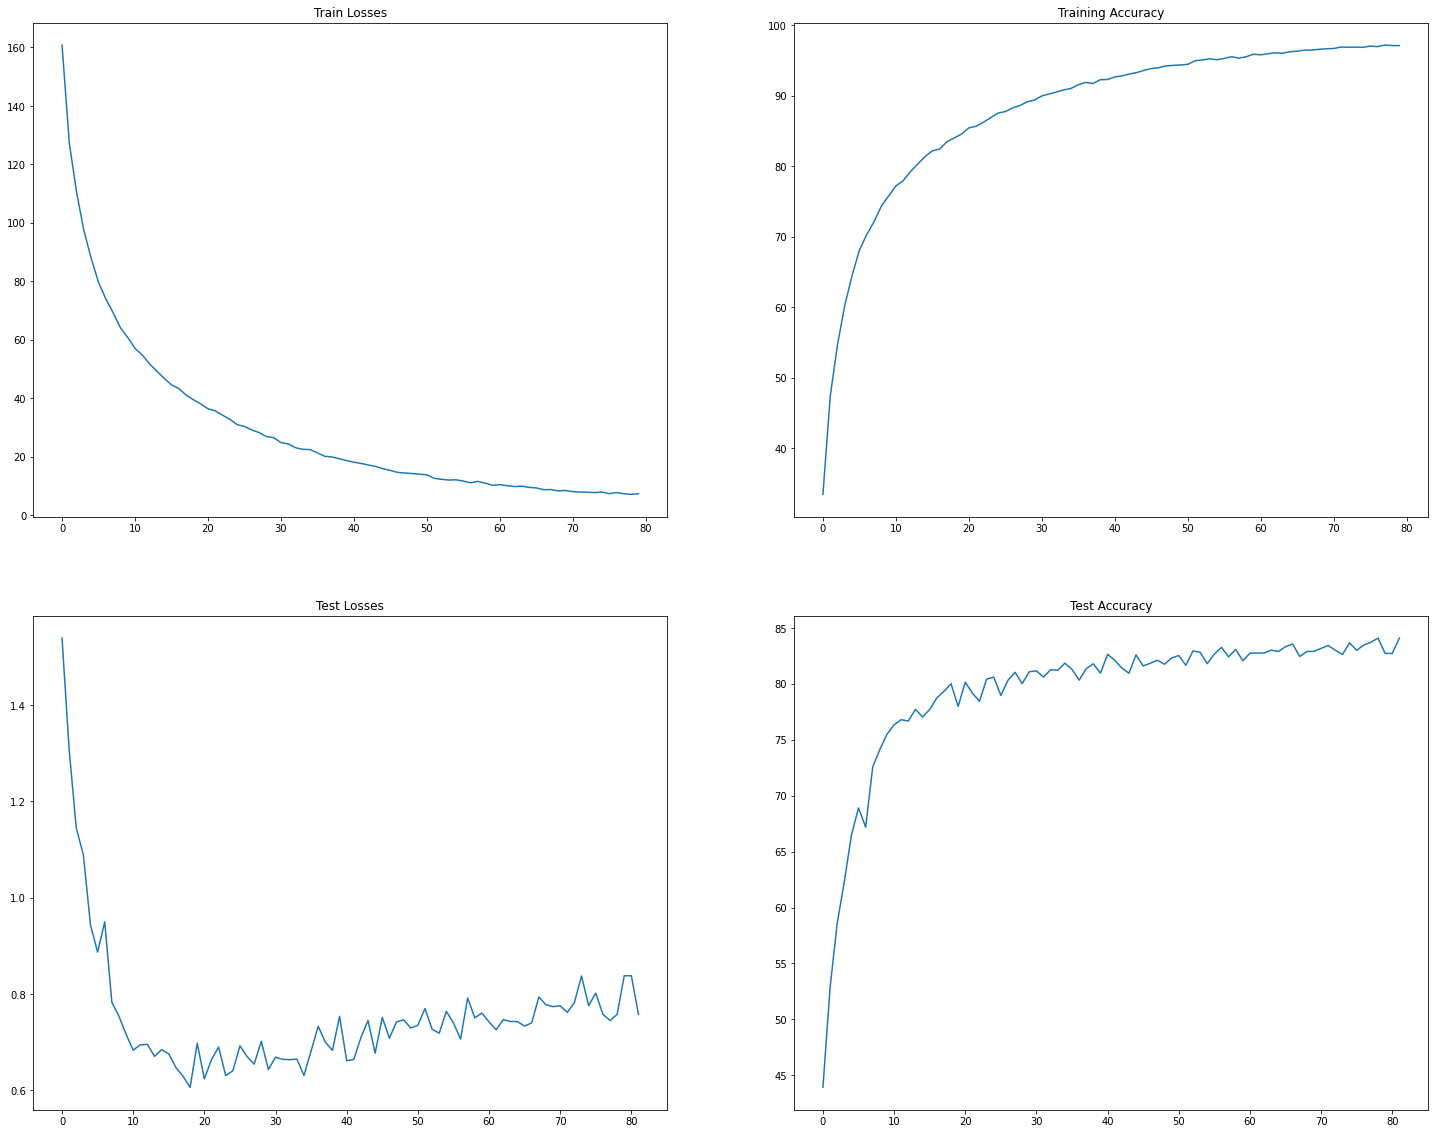

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(25,20))

axs[0,0].set_title('Train Losses')
axs[0,1].set_title('Training Accuracy')
axs[1,0].set_title('Test Losses')
axs[1,1].set_title('Test Accuracy')

axs[0,0].plot(train_losses)
axs[0,1].plot(train_acc)
axs[1,0].plot(test_losses)
axs[1,1].plot(test_acc)